<h1>Semantic Segmentation</h1>

<h3>Importing the required libraries</h3>
<ul>
    <li>Numpy - for linear algebra</li>
    <li>os - file and path manipuation in machine</li>
    <li>matplotlib - Graph visualization</li>
    <li>PIL and CV2 - image processing and loading</li>
    <li>scikit-learn KMeans - Color clustering</li>
    <li>random - Generating random numbers and choices</li>
    <li>keras - High level interface to tensorflow (for neural networks)</li>
</ul>


In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


<h3>LoadImage</h3>
This function will load image from file path, it allows simple data manipulation like flipping and rotating. Dataset has side by side images of raw and color coded segmented image. It will splits the image into seperate image.



In [2]:
def LoadImage(name, path=r"C:\Users\dextr\2020_FinalYearProject\cityscapes-image-pairs\cityscapes_data\train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

<h3>Color clustering</h3>
After the compression of images, only the few distinct color remains segmented in image. I had to use KMeans clustering to find important color and identify similor color. This is the transition of color to class representation.


In [3]:
files =os.listdir(r"C:\Users\dextr\2020_FinalYearProject\cityscapes-image-pairs\cityscapes_data\train")[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<h3>Layers to RGB Image</h3>
Includes details about 13 separate layers after clustering the file. The RGB colorspace can only be used for device displays. This feature transforms the representation of layer into color. This is just to improve image visualizaztion.


In [5]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

<h3>Colors to Class</h3>
This function converts color clustering output into 13 dimensional representation of class. This will later help the machine to learn the algorithm. Output has shown the layered classification.

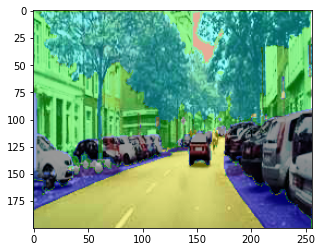

<Figure size 1440x720 with 0 Axes>

In [6]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage("169.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.figure(figsize=(20, 10))
plot.show()

<h3>The Data Generator</h3>
To make training more memory efficient a generator is used for feeding the data to the deep learning algorithm. 
This generator creates batches of raw segmented image pair at a moment. It uses image manipulation like random flips and rotation to increase the efficiency size of dataset.

Shown in output

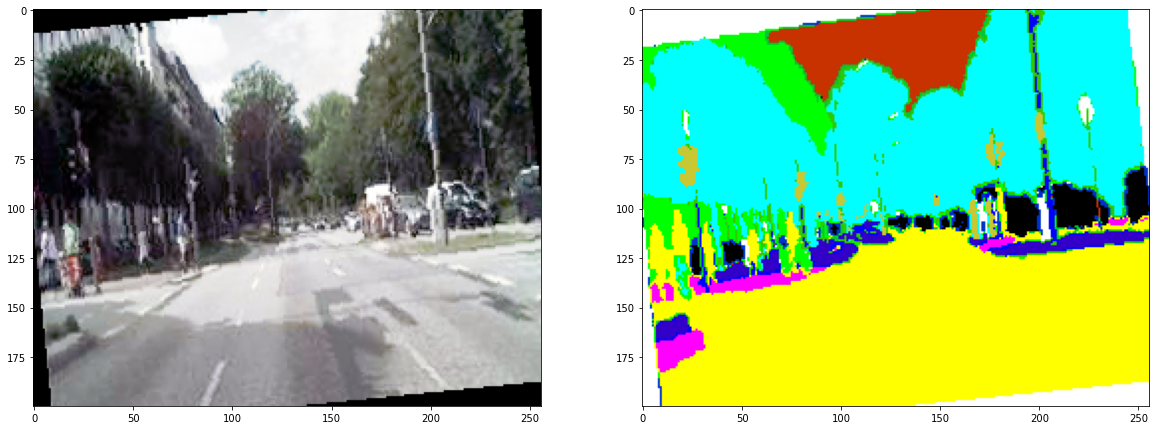

In [7]:
def Generate(path=r"C:\Users\dextr\2020_FinalYearProject\cityscapes-image-pairs\cityscapes_data\train", batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,2)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.figure(figsize=(20, 10))
plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()

<h3>Convolutional Neural Network - UNet</h3>
This is a specific form of CNN, which utilizes concatenate layers to feed data from previous layers into near-output layers. The network is built like a double-funnel. Data flow through guarantees that no data is lost. Otherwise the form of the funnel will allow an auto encoder to be quite identical.

In [8]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)

x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)

x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)

x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)


x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)


x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)


x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 256, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 256, 64) 27712       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 200, 256, 128 1179776     conv2d_1[0][0]                   
____________________________________________________________________________________________

The network has 9 million trainable parameters.

The next step is to create two generators:
<ul>
    <li>Training generator - for training data</li>
    <li>Validation generator - to prevent overfitting</li>
    </ul>

In [9]:
train_gen = Generate()
val_gen = Generate(r"C:\Users\dextr\2020_FinalYearProject\cityscapes-image-pairs\cityscapes_data\val")

<h3>Training</h3>
I have trained this model at 20 epochs and used a Model Checkpoint to save the model which have slightest validation loss.

In [ ]:
clb = [ModelCheckpoint("loss.h5", save_best_only=True, verbose=0)]

h = model.fit_generator(train_gen, epochs=20, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=0)

Saving the model and loading the best model of out whole training.


In [10]:
model.save("model.h5")
model = load_model("loss.h5")

Graph visualization of validation loss and validation accuracy.

**As I have said in screencast video, I have to train the model again to show you the graph of validation accuracy and validation loss. In source code folder you can see learn.png file which was the output of this cell after the model got trained at 20 epochs.**

In [11]:
loss = h.history["val_loss"]
acc = h.history["val_accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

NameError: name 'h' is not defined

<h3>Results</h3>
Few test images are being tested to see how CNN is working. To be very confident that there is no overfitting one should have split from the training dataset even from a test collection.


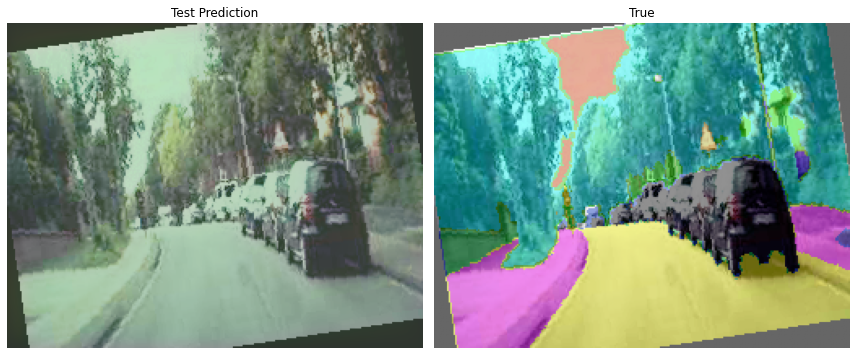

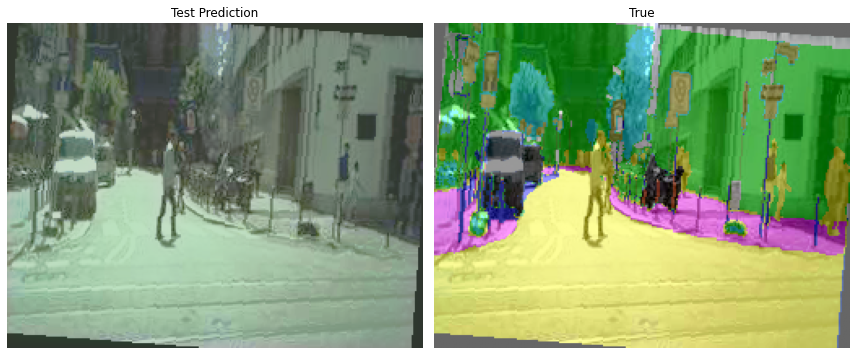

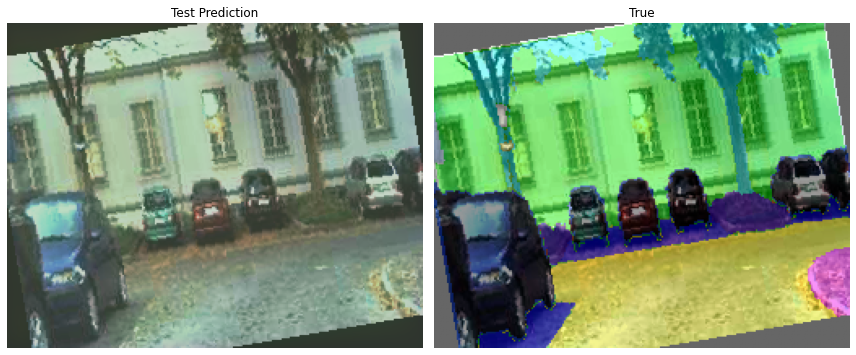

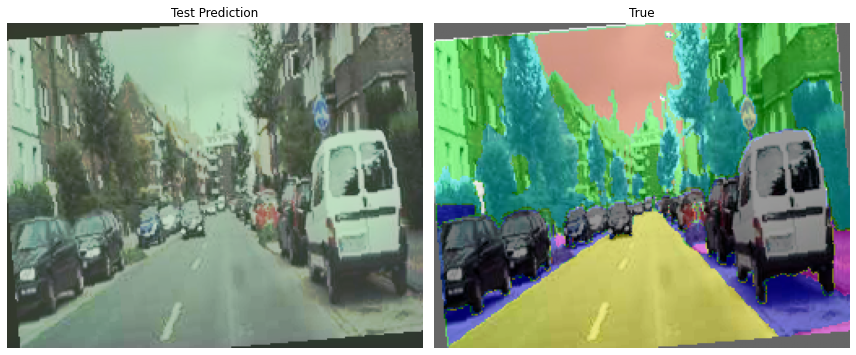

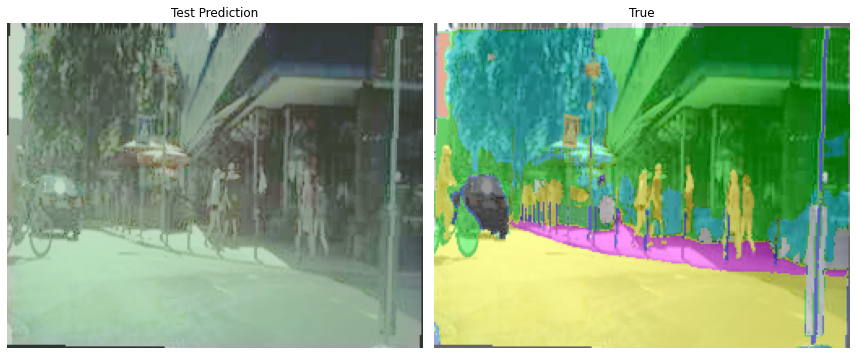

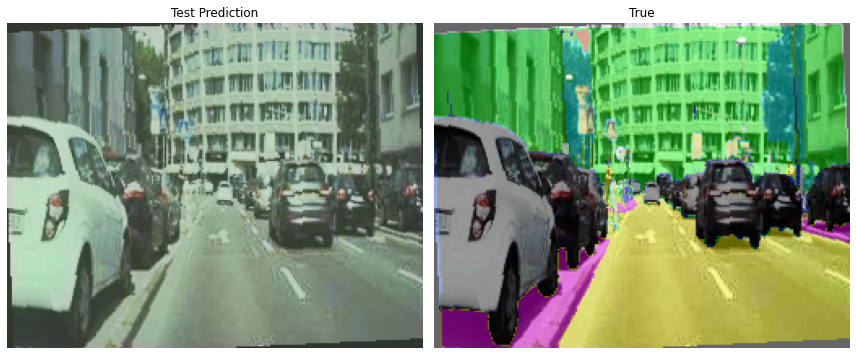

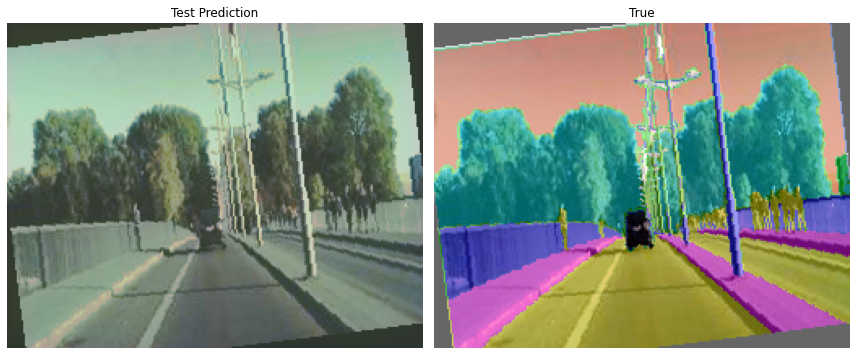

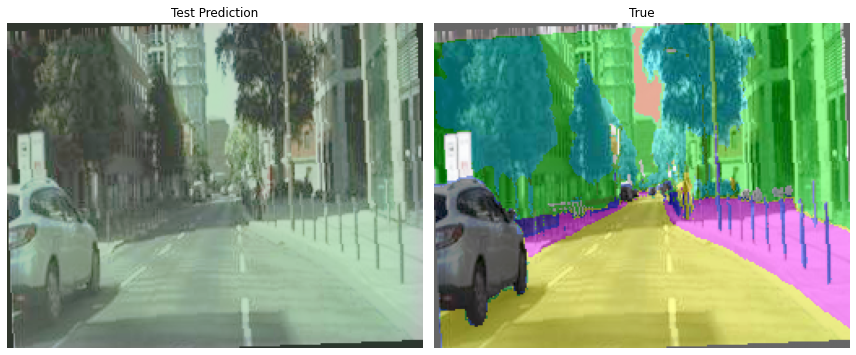

In [12]:
test_gen = Generate(r"C:\Users\dextr\2020_FinalYearProject\cityscapes-image-pairs\cityscapes_data\val")
max_show=20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Test Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

<h3>ROC Curve</h3>
Receiver Operating Characteristic curve quatifying the quality of prediction.

C:\Users\dextr\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


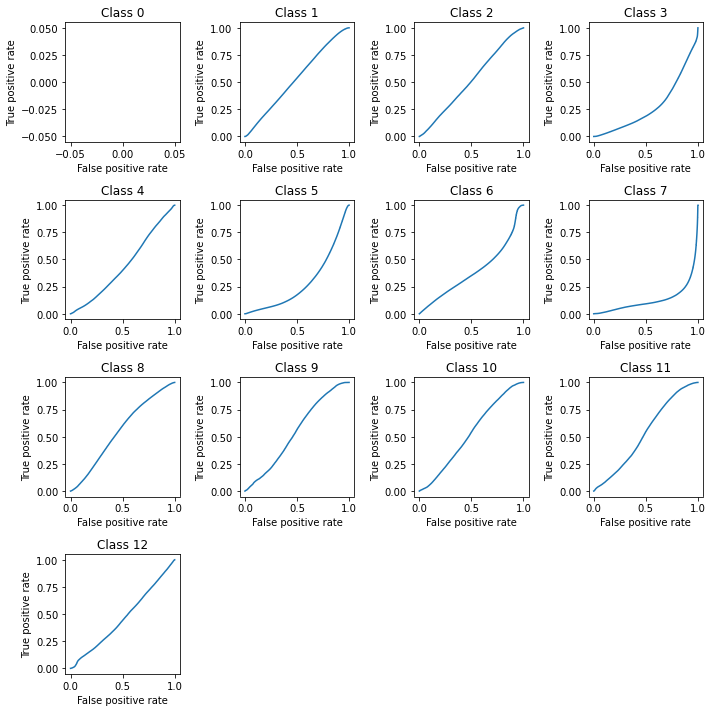

In [13]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = Generate(r"C:\Users\dextr\2020_FinalYearProject\cityscapes-image-pairs\cityscapes_data\val", batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")
    
    plot.tight_layout()
    plot.show()
    
    break

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

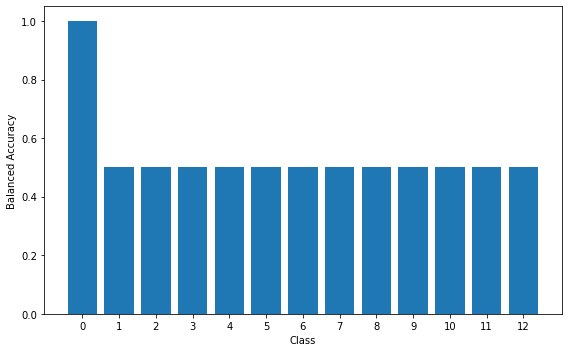

In [14]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("visualgraph.png")
plot.show()